<h1>MCE Static Map Generator</h1>

<p>David J. Waro, May 23rd, 2018</p>

In [2]:
%matplotlib inline
import os
import geopandas as gpd
import numpy as np
import json
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.pyplot import Text as text
from matplotlib.patches import Circle
from geopandas.plotting import plot_polygon_collection
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDrawingArea

/home/tflory/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [4]:
yr = 2017

In [5]:
def employee_colors(emp_size_col, employee_quantiles):
    """ Takes in the geodataframe's list at emp_size and the employee size quantile splits and returns a new list of 
        that emp_size color """
    emp_color = []
    for emp_size in emp_size_col:
        if emp_size <= employee_quantiles[0]:
            emp_color.append('#ffffb2')
        elif emp_size > employee_quantiles[0] and emp_size <= employee_quantiles[1]:
            emp_color.append('#fecc5c')
        elif emp_size > employee_quantiles[1] and emp_size <= employee_quantiles[2]:
            emp_color.append('#fd8d3c')
        elif emp_size > employee_quantiles[2] and emp_size <= employee_quantiles[3]:
            emp_color.append('#f03b20')
        else:
            emp_color.append('#bd0026')
            
    return emp_color

<h2>Read in shapefiles and filter for contiguous 48, Alaskan, and Hawaiian counties</h2>

In [6]:
# us counties and congressional districts shapefiles
dir = '/Volumes/480SSD/InfoGroup/data/0.2/%d/for_mapping/' % yr
us_counties = gpd.read_file(dir + 'UScounties/UScounties.shp')
congressional_districts = gpd.read_file(dir + 'Cdistricts/cb_2017_us_cd115_5m.shp') # shapes from US Census

# filter for 48 contiguous US counties
filter = (us_counties['STATE_FIPS'] != '02') & (us_counties['STATE_FIPS'] != '15')
contig_counties = us_counties[filter]
contig_counties = contig_counties.to_crs({'init': 'epsg:6579'})

# filter for Alaskan counties
filter = us_counties['STATE_FIPS'] == '02'
alaska_counties = us_counties[filter]
alaska_counties = alaska_counties.to_crs({'init':'epsg:3338'})

# filter for Hawaiian
filter = us_counties['STATE_FIPS'] == '15'
hawaii_counties = us_counties[filter]
hawaii_counties = hawaii_counties.to_crs({'init': 'epsg:3750'})

In [7]:
coop_geojson = dir + 'map_data_%d_temp.geojson' % yr
with open(coop_geojson) as f:
    data = json.load(f)

<h2>Setup Cooperative data to work with in GeoPandas</h2>

In [8]:
coop_data = gpd.GeoDataFrame() # create an empty geodataframe

# lists to hold information extracted from geojson's features
company = []
search_add = []
emp_size = []
sales_vol = []
sector_code = []
coordinates = []

# populate lists
for feature in data['features']:
    company.append(feature['properties']['Company'])
    search_add.append(feature['properties']['Search_Add'])
    emp_size.append(feature['properties']['Emp_Size'])
    sales_vol.append(feature['properties']['Sales_Vol'])
    sector_code.append(feature['properties']['Sector_Code'])
    coordinates.append(feature['geometry']['coordinates'])

# add information from the geojson to the new geodataframe
coop_data['Company'] = company
coop_data['Search_Add'] = search_add
coop_data['Emp_Size'] = emp_size
coop_data['Sales_Vol'] = sales_vol
coop_data['Sector_Code'] = sector_code
coop_data['Coordinates'] = coordinates

# assign point geometries to the geodataframe from the geojson
coop_data.geometry = [Point(coordinate[0], coordinate[1]) for coordinate in coop_data['Coordinates']]
coop_data.crs = {'init': 'epsg:4326'} # set coordinate system to WGS 84 (non-projected, web format)

# create a state field to then be used to separate contiguous US from Hawaii and Alaska
state = []
for address in coop_data['Search_Add']:
    state.append(address[len(address)-2:len(address)])

# filter the points for the contiguous US, Alaska, and Hawaii
coop_data['State'] = state

In [9]:
coop_data.Emp_Size = coop_data.Emp_Size.astype(np.int64)
employee_quantiles = []
for quant_break in coop_data.Emp_Size.quantile([0.2, 0.4, 0.6, 0.8]):
    employee_quantiles.append(quant_break)

states_filter = (coop_data['State'] != 'AK') & (coop_data['State'] != 'HI') & (coop_data['State'] != 'PR')
alaska_filter = (coop_data['State'] == 'AK')
hawaii_filter = (coop_data['State'] == 'HI')

contig_points = coop_data[states_filter]

# project contiguous points as Texas Centric Albers Equal Area NAD83(2011)
contig_points = contig_points.to_crs({'init': 'epsg:6579'})

<h2>Assign colors to points based on their sectors</h2>

In [10]:
point_colors = []
for sector in contig_points['Sector_Code']:
    if int(sector) >= 10 and int(sector) < 20:
        point_colors.append('blue')
    elif int(sector) >= 20 and int(sector) < 30:
        point_colors.append('red')
    elif int(sector) >= 30 and int(sector) < 40:
        point_colors.append('orange')
    elif int(sector) >= 40 and int(sector) < 50:
        point_colors.append('green')
    else:
        point_colors.append('black')

contig_points['Color'] = point_colors

alaska_points = coop_data[alaska_filter]
alaska_points = alaska_points.to_crs({'init': 'epsg:3338'}) # project Alaskan points as NAD83 / Alaska Albers

ak_colors = []
for sector in alaska_points['Sector_Code']:
    if int(sector) >= 10 and int(sector) < 20:
        ak_colors.append('blue')
    elif int(sector) >= 20 and int(sector) < 30:
        ak_colors.append('red')
    elif int(sector) >= 30 and int(sector) < 40:
        ak_colors.append('orange')
    elif int(sector) >= 40 and int(sector) < 50:
        ak_colors.append('green')
    else:
        ak_colors.append('black')

alaska_points['Color'] = ak_colors

hawaii_points = coop_data[hawaii_filter]
hawaii_points = hawaii_points.to_crs({'init': 'epsg:3750'}) # project Hawaiian points as NAD83(HARN) / UTM zone 4N

hi_colors = []
for sector in hawaii_points['Sector_Code']:
    if int(sector) >= 10 and int(sector) < 20:
        hi_colors.append('blue')
    elif int(sector) >= 20 and int(sector) < 30:
        hi_colors.append('red')
    elif int(sector) >= 30 and int(sector) < 40:
        hi_colors.append('orange')
    elif int(sector) >= 40 and int(sector) < 50:
        hi_colors.append('green')
    else:
        hi_colors.append('black')

hawaii_points['Color'] = hi_colors

# create column of colors to be used for representing employee sizes
contig_points['Emp_Color'] = employee_colors(contig_points['Emp_Size'], employee_quantiles)
alaska_points['Emp_Color'] = employee_colors(alaska_points['Emp_Size'], employee_quantiles)
hawaii_points['Emp_Color'] = employee_colors(hawaii_points['Emp_Size'], employee_quantiles)

<h2>Filter between contiguous 48, Alaska, and Hawaii for each sector</h2>

In [11]:
contig_comm_filter = (contig_points['Color'] == 'blue')
contig_comm_points = contig_points[contig_comm_filter]

contig_fin_filter = (contig_points['Color'] == 'red')
contig_fin_points = contig_points[contig_fin_filter]

contig_soc_filter = (contig_points['Color'] == 'orange')
contig_soc_points = contig_points[contig_soc_filter]

contig_util_filter = (contig_points['Color'] == 'green')
contig_util_points = contig_points[contig_util_filter]

ak_comm_filter = (alaska_points['Color'] == 'blue')
ak_comm_points = alaska_points[ak_comm_filter]

ak_fin_filter = (alaska_points['Color'] == 'red')
ak_fin_points = alaska_points[ak_fin_filter]

ak_soc_filter = (alaska_points['Color'] == 'orange')
ak_soc_points = alaska_points[ak_soc_filter]

ak_util_filter = (alaska_points['Color'] == 'green')
ak_util_points = alaska_points[ak_util_filter]

hi_comm_filter = (hawaii_points['Color'] == 'blue')
hi_comm_points = hawaii_points[hi_comm_filter]

hi_fin_filter = (hawaii_points['Color'] == 'red')
hi_fin_points = hawaii_points[hi_fin_filter]

hi_soc_filter = (hawaii_points['Color'] == 'orange')
hi_soc_points = hawaii_points[hi_soc_filter]

hi_util_filter = (hawaii_points['Color'] == 'green')
hi_util_points = hawaii_points[hi_util_filter]

<h2>Congressional Districts Work</h2>

In [12]:
congressional_districts.STATEFP = congressional_districts.STATEFP.astype(np.int64)
coop_data.Sector_Code = coop_data.Sector_Code.astype(np.int64)

# filter out commonwealth and territories that are included from US Census congressional districts shapefile
congressional_districts = congressional_districts[congressional_districts['STATEFP'] < 60]

# COLOR SCHEMES FOR CHOROPLETH MAPS
all_color_scheme = ['#ffffcc','#a1dab4','#41b6c4','#2c7fb8','#253494']
comm_color_scheme = ['#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c']
fin_color_scheme = ['#fee5d9','#fcae91','#fb6a4a','#de2d26','#a50f15']
soc_color_scheme = ['#ffffd4','#fed98e','#fe9929','#d95f0e','#993404']
util_color_scheme = ['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']

# copy because we will be dropping points in place as they are found within a boundary
coop_data_copy = coop_data.copy()

# filter for sectoral points
commercial_points = coop_data[(coop_data['Sector_Code'] >= 10) & (coop_data['Sector_Code'] < 20)]
financial_points = coop_data[(coop_data['Sector_Code'] >= 20) & (coop_data['Sector_Code'] < 30)]
social_points = coop_data[(coop_data['Sector_Code'] >= 30) & (coop_data['Sector_Code'] < 40)]
utility_points = coop_data[(coop_data['Sector_Code'] >= 40) & (coop_data['Sector_Code'] < 50)]

<h2>Counting commercial, financial, social and utility points within congressional district boundaries</h2>

In [14]:
%%time
comm_in_districts = []
for i, polygon in congressional_districts.iterrows():
    pts_in_this_dist = 0
    for j, point in commercial_points.iterrows():
        if polygon.geometry.contains(point.geometry):
            pts_in_this_dist += 1
            commercial_points = commercial_points.drop([j])
    comm_in_districts.append(pts_in_this_dist)

fin_in_districts = []
for i, polygon in congressional_districts.iterrows():
    pts_in_this_dist = 0
    for j, point in financial_points.iterrows():
        if polygon.geometry.contains(point.geometry):
            pts_in_this_dist += 1
            financial_points = financial_points.drop([j])
    fin_in_districts.append(pts_in_this_dist)

soc_in_districts = []
for i, polygon in congressional_districts.iterrows():
    pts_in_this_dist = 0
    for j, point in social_points.iterrows():
        if polygon.geometry.contains(point.geometry):
            pts_in_this_dist += 1
            social_points = social_points.drop([j])
    soc_in_districts.append(pts_in_this_dist)

util_in_districts = []
for i, polygon in congressional_districts.iterrows():
    pts_in_this_dist = 0
    for j, point in utility_points.iterrows():
        if polygon.geometry.contains(point.geometry):
            pts_in_this_dist += 1
            utility_points = utility_points.drop([j])
    util_in_districts.append(pts_in_this_dist)

congressional_districts['Comm_Counts'] = comm_in_districts
congressional_districts['Fin_Counts'] = fin_in_districts
congressional_districts['Soc_Counts'] = soc_in_districts
congressional_districts['Util_Counts'] = util_in_districts

# ALTERNATIVE WAY TO COUNT TOTAL COOPERATIVES IN EACH DISTRICT, SLIGHTLY MORE ACCURATE BECAUSE INCLUDES UNKNOWN 
# SECTOR, BUT DOUBLES THE TIME TO RUN THE COUNTS

# count total cooperatives in each us congressional district
# pts_in_districts = []
# for i, polygon in congressional_districts.iterrows():
    #pts_in_this_dist = 0
    #for j, point in coop_data_copy.iterrows():
        #if polygon.geometry.contains(point.geometry):
            #pts_in_this_dist += 1
            #coop_data_copy = coop_data_copy.drop([j])
    #pts_in_districts.append(pts_in_this_dist)

#congressional_districts['Num_Coops'] = pts_in_districts

# Sum sector counts to get the total number of coops in each district
congressional_districts['Num_Coops'] = congressional_districts['Comm_Counts'] + congressional_districts['Fin_Counts'] + congressional_districts['Soc_Counts'] + congressional_districts['Util_Counts']

CPU times: user 46min 9s, sys: 472 ms, total: 46min 9s
Wall time: 46min 9s


<h2>Convert from meters to miles</h2>

In [15]:
# ALAND listed as square meters, we want square miles
congressional_districts['Area_SQ_Miles'] = congressional_districts['ALAND'] * 0.000000386102159 # to sq. miles
congressional_districts['Area_100_SQ_Miles'] = congressional_districts.Area_SQ_Miles / 100.00 # scale back
congressional_districts['Coops_Per_100_SQ_Miles'] = congressional_districts.Num_Coops / congressional_districts.Area_100_SQ_Miles

<h2>Quantiles and filtering districts</h2>

In [16]:
# break coops per 100 square miles into quantile breaks for color scheme
overall_quantiles = []
for quant_break in congressional_districts.Coops_Per_100_SQ_Miles.quantile([0.2, 0.4, 0.6, 0.8]):
    overall_quantiles.append(quant_break)

# filter for 48 contiguous US Districts to now include counts
filter = (congressional_districts['STATEFP'] < 60) & (congressional_districts['STATEFP'] != 2) & (congressional_districts['STATEFP'] != 15)
contig_districts = congressional_districts[filter]
contig_districts = contig_districts.to_crs({'init': 'epsg:6579'})

# filter for Alaskan districts to now include counts
ak_dist_filter = congressional_districts['STATEFP'] == 2
ak_districts = congressional_districts[ak_dist_filter]
ak_districts = ak_districts.to_crs({'init':'epsg:3338'})

# filter for Hawaiian districts to now include counts
hi_dist_filter = congressional_districts['STATEFP'] == 15
hi_districts = congressional_districts[hi_dist_filter]
hi_districts = hi_districts.to_crs({'init': 'epsg:3750'})

<h2>Coloring districts for cooperative counts</h2>

In [17]:
contig_colors = []
for i, district in contig_districts.iterrows():
    contig_color = '#ffffff'
    # first quantile
    if district.Coops_Per_100_SQ_Miles <= overall_quantiles[0]:
        contig_color = all_color_scheme[0]
    # second quantile
    elif district.Coops_Per_100_SQ_Miles > overall_quantiles[0] and district.Coops_Per_100_SQ_Miles <= overall_quantiles[1]:
        contig_color = all_color_scheme[1]
    # third quantile
    elif district.Coops_Per_100_SQ_Miles > overall_quantiles[1] and district.Coops_Per_100_SQ_Miles <= overall_quantiles[2]:
        contig_color = all_color_scheme[2]
    # fourth quantile
    elif district.Coops_Per_100_SQ_Miles > overall_quantiles[2] and district.Coops_Per_100_SQ_Miles <= overall_quantiles[3]:
        contig_color = all_color_scheme[3]
    # fifth quantile
    else:
        contig_color = all_color_scheme[4]
        
    contig_colors.append(contig_color)

ak_color = '#ffffff'
for i, district in ak_districts.iterrows():
    if district.Coops_Per_100_SQ_Miles <= overall_quantiles[0]:
        ak_color = all_color_scheme[0]
    elif district.Coops_Per_100_SQ_Miles > overall_quantiles[0] and district.Coops_Per_100_SQ_Miles <= overall_quantiles[1]:
        ak_color = all_color_scheme[1]
    elif district.Coops_Per_100_SQ_Miles > overall_quantiles[1] and district.Coops_Per_100_SQ_Miles <= overall_quantiles[2]:
        ak_color = all_color_scheme[2]
    elif district.Coops_Per_100_SQ_Miles > overall_quantiles[2] and district.Coops_Per_100_SQ_Miles <= overall_quantiles[3]:
        ak_color = all_color_scheme[3]
    else:
        ak_color = all_color_scheme[4]

hi_colors = []
for i, district in hi_districts.iterrows():
    hi_color = '#ffffff'
    if district.Coops_Per_100_SQ_Miles <= overall_quantiles[0]:
        hi_color = all_color_scheme[0]
    elif district.Coops_Per_100_SQ_Miles > overall_quantiles[0] and district.Coops_Per_100_SQ_Miles <= overall_quantiles[1]:
        hi_color = all_color_scheme[1]
    elif district.Coops_Per_100_SQ_Miles > overall_quantiles[1] and district.Coops_Per_100_SQ_Miles <= overall_quantiles[2]:
        hi_color = all_color_scheme[2]
    elif district.Coops_Per_100_SQ_Miles > overall_quantiles[2] and district.Coops_Per_100_SQ_Miles <= overall_quantiles[3]:
        hi_color = all_color_scheme[3]
    else:
        hi_color = all_color_scheme[4]
    
    hi_colors.append(hi_color)

<h2>Normalizing sector district counts by area and re-filtering</h2>

In [18]:
# Normalize the sector counts by the area per 100 square miles
congressional_districts['Comm_Norm'] = congressional_districts['Comm_Counts'] / congressional_districts['Area_100_SQ_Miles']
congressional_districts['Fin_Norm'] = congressional_districts['Fin_Counts'] / congressional_districts['Area_100_SQ_Miles']
congressional_districts['Soc_Norm'] = congressional_districts['Soc_Counts'] / congressional_districts['Area_100_SQ_Miles']
congressional_districts['Util_Norm'] = congressional_districts['Util_Counts'] / congressional_districts['Area_100_SQ_Miles']

# filter for 48 contiguous US Districts
filter = (congressional_districts['STATEFP'] < 60) & (congressional_districts['STATEFP'] != 2) & (congressional_districts['STATEFP'] != 15)
contig_districts = congressional_districts[filter]
contig_districts = contig_districts.to_crs({'init': 'epsg:6579'})

# filter for Alaskan districts
ak_dist_filter = congressional_districts['STATEFP'] == 2
ak_districts = congressional_districts[ak_dist_filter]
ak_districts = ak_districts.to_crs({'init':'epsg:3338'})

# filter for Hawaiian districts
hi_dist_filter = congressional_districts['STATEFP'] == 15
hi_districts = congressional_districts[hi_dist_filter]
hi_districts = hi_districts.to_crs({'init': 'epsg:3750'})

<h2>Sector quantile breaks</h2>

In [19]:
# quantile breaks for each sector to be used for coloring choropleths
comm_quantiles = []
for quant_break in congressional_districts.Comm_Norm.quantile([0.2, 0.4, 0.6, 0.8]):
    comm_quantiles.append(quant_break)

fin_quantiles = []
for quant_break in congressional_districts.Fin_Norm.quantile([0.2, 0.4, 0.6, 0.8]):
    fin_quantiles.append(quant_break)

soc_quantiles = []
for quant_break in congressional_districts.Soc_Norm.quantile([0.2, 0.4, 0.6, 0.8]):
    soc_quantiles.append(quant_break)

util_quantiles = []
for quant_break in congressional_districts.Util_Norm.quantile([0.2, 0.4, 0.6, 0.8]):
    util_quantiles.append(quant_break)

<h2>Coloring districts for contiguous district counts</h2>

In [20]:
contig_comm_colors = []
contig_fin_colors = []
contig_soc_colors = []
contig_util_colors = []

for i, district in contig_districts.iterrows():

    #### commercial
    contig_comm_color = '#ffffff'
    if district.Comm_Norm <= comm_quantiles[0]:
        contig_comm_color = comm_color_scheme[0]
    elif district.Comm_Norm > comm_quantiles[0] and district.Comm_Norm <= comm_quantiles[1]:
        contig_comm_color = comm_color_scheme[1]
    elif district.Comm_Norm > comm_quantiles[1] and district.Comm_Norm <= comm_quantiles[2]:
        contig_comm_color = comm_color_scheme[2]
    elif district.Comm_Norm > comm_quantiles[2] and district.Comm_Norm <= comm_quantiles[3]:
        contig_comm_color = comm_color_scheme[3]
    else:
        contig_comm_color = comm_color_scheme[4]
    
    contig_comm_colors.append(contig_comm_color)

    #### financial
    contig_fin_color = '#ffffff'
    if district.Fin_Norm <= fin_quantiles[0]:
        contig_fin_color = fin_color_scheme[0]
    elif district.Fin_Norm > fin_quantiles[0] and district.Fin_Norm <= fin_quantiles[1]:
        contig_fin_color = fin_color_scheme[1]
    elif district.Fin_Norm > fin_quantiles[1] and district.Fin_Norm <= fin_quantiles[2]:
        contig_fin_color = fin_color_scheme[2]
    elif district.Fin_Norm > fin_quantiles[2] and district.Fin_Norm <= fin_quantiles[3]:
        contig_fin_color = fin_color_scheme[3]
    else:
        contig_fin_color = fin_color_scheme[4]

    contig_fin_colors.append(contig_fin_color)

    #### social
    contig_soc_color = '#ffffff'
    if district.Soc_Norm <= soc_quantiles[0]:
        contig_soc_color = soc_color_scheme[0]
    elif district.Soc_Norm > soc_quantiles[0] and district.Soc_Norm <= soc_quantiles[1]:
        contig_soc_color = soc_color_scheme[1]
    elif district.Soc_Norm > soc_quantiles[1] and district.Soc_Norm <= soc_quantiles[2]:
        contig_soc_color = soc_color_scheme[2]
    elif district.Soc_Norm > soc_quantiles[2] and district.Soc_Norm <= soc_quantiles[3]:
        contig_soc_color = soc_color_scheme[3]
    else:
        contig_soc_color = soc_color_scheme[4]
    
    contig_soc_colors.append(contig_soc_color)

    #### utilities
    contig_util_color = '#ffffff'
    
    if district.Util_Norm == 0:
        contig_util_color = util_color_scheme[0]
    elif district.Util_Norm <= util_quantiles[0]:
        contig_util_color = util_color_scheme[0]
    elif district.Util_Norm > util_quantiles[0] and district.Util_Norm <= util_quantiles[1]:
        contig_util_color = util_color_scheme[1]
    elif district.Util_Norm > util_quantiles[1] and district.Util_Norm <= util_quantiles[2]:
        contig_util_color = util_color_scheme[2]
    elif district.Util_Norm > util_quantiles[2] and district.Util_Norm <= util_quantiles[3]:
        contig_util_color = util_color_scheme[3]
    else:
        contig_util_color = util_color_scheme[4]
        
    contig_util_colors.append(contig_util_color)

<h2>Coloring districts for Alaskan district counts</h2>

In [21]:
ak_comm_color = '#ffffff'
ak_fin_color = '#ffffff'
ak_soc_color = '#ffffff'
ak_util_color = '#ffffff'

for i, district in ak_districts.iterrows():

    #### commercial
    if district.Comm_Norm <= comm_quantiles[0]:
        ak_comm_color = comm_color_scheme[0]
    elif district.Comm_Norm > comm_quantiles[0] and district.Comm_Norm <= comm_quantiles[1]:
        ak_comm_color = comm_color_scheme[1]
    elif district.Comm_Norm > comm_quantiles[1] and district.Comm_Norm <= comm_quantiles[2]:
        ak_comm_color = comm_color_scheme[2]
    elif district.Comm_Norm > comm_quantiles[2] and district.Comm_Norm <= comm_quantiles[3]:
        ak_comm_color = comm_color_scheme[3]
    else:
        ak_comm_color = comm_color_scheme[4]

    #### financial
    if district.Fin_Norm <= fin_quantiles[0]:
        ak_fin_color = fin_color_scheme[0]
    elif district.Fin_Norm > fin_quantiles[0] and district.Fin_Norm <= fin_quantiles[1]:
        ak_fin_color = fin_color_scheme[1]
    elif district.Fin_Norm > fin_quantiles[1] and district.Fin_Norm <= fin_quantiles[2]:
        ak_fin_color = fin_color_scheme[2]
    elif district.Fin_Norm > fin_quantiles[2] and district.Fin_Norm <= fin_quantiles[3]:
        ak_fin_color = fin_color_scheme[3]
    else:
        ak_fin_color = fin_color_scheme[4]

    #### social
    if district.Soc_Norm == 0:
        ak_soc_color = soc_color_scheme[0]
    elif district.Soc_Norm <= soc_quantiles[0]:
        ak_soc_color = soc_color_scheme[0]
    elif district.Soc_Norm > soc_quantiles[0] and district.Soc_Norm <= soc_quantiles[1]:
        ak_soc_color = soc_color_scheme[1]
    elif district.Soc_Norm > soc_quantiles[1] and district.Soc_Norm <= soc_quantiles[2]:
        ak_soc_color = soc_color_scheme[2]
    elif district.Soc_Norm > soc_quantiles[2] and district.Soc_Norm <= soc_quantiles[3]:
        ak_soc_color = soc_color_scheme[3]
    else:
        ak_soc_color = soc_color_scheme[4]

    #### utilities
    if district.Util_Norm == 0:
        ak_util_color = util_color_scheme[0]
    elif district.Util_Norm <= util_quantiles[0]:
        ak_util_color = util_color_scheme[0]
    elif district.Util_Norm > util_quantiles[0] and district.Util_Norm <= util_quantiles[1]:
        ak_util_color = util_color_scheme[1]
    elif district.Util_Norm > util_quantiles[1] and district.Util_Norm <= util_quantiles[2]:
        ak_util_color = util_color_scheme[2]
    elif district.Util_Norm > util_quantiles[2] and district.Util_Norm <= util_quantiles[3]:
        ak_util_color = util_color_scheme[3]
    else:
        ak_util_color = util_color_scheme[4]

<h2>Coloring districts for Hawaiian district counts</h2>

In [22]:
hi_comm_colors = []
hi_fin_colors = []
hi_soc_colors = []
hi_util_colors = []

for i, district in hi_districts.iterrows():

    #### commercial
    hi_comm_color = '#ffffff'
    if district.Comm_Norm <= comm_quantiles[0]:
        hi_comm_color = comm_color_scheme[0]
    elif district.Comm_Norm > comm_quantiles[0] and district.Comm_Norm <= comm_quantiles[1]:
        hi_comm_color = comm_color_scheme[1]
    elif district.Comm_Norm > comm_quantiles[1] and district.Comm_Norm <= comm_quantiles[2]:
        hi_comm_color = comm_color_scheme[2]
    elif district.Comm_Norm > comm_quantiles[2] and district.Comm_Norm <= comm_quantiles[3]:
        hi_comm_color = comm_color_scheme[3]
    else:
        hi_comm_color = comm_color_scheme[4]

    hi_comm_colors.append(hi_comm_color)

    #### financial
    hi_fin_color = '#ffffff'
    if district.Fin_Norm <= fin_quantiles[0]:
        hi_fin_color = fin_color_scheme[0]
    elif district.Fin_Norm > fin_quantiles[0] and district.Fin_Norm <= fin_quantiles[1]:
        hi_fin_color = fin_color_scheme[1]
    elif district.Fin_Norm > fin_quantiles[1] and district.Fin_Norm <= fin_quantiles[2]:
        hi_fin_color = fin_color_scheme[2]
    elif district.Fin_Norm > fin_quantiles[2] and district.Fin_Norm <= fin_quantiles[3]:
        hi_fin_color = fin_color_scheme[3]
    else:
        hi_fin_color = fin_color_scheme[4]

    hi_fin_colors.append(hi_fin_color)

    #### social
    hi_soc_color = '#ffffff'
    if district.Soc_Norm <= soc_quantiles[0]:
        hi_soc_color = soc_color_scheme[0]
    elif district.Soc_Norm > soc_quantiles[0] and district.Soc_Norm <= soc_quantiles[1]:
        hi_soc_color = soc_color_scheme[1]
    elif district.Soc_Norm > soc_quantiles[1] and district.Soc_Norm <= soc_quantiles[2]:
        hi_soc_color = soc_color_scheme[2]
    elif district.Soc_Norm > soc_quantiles[2] and district.Soc_Norm <= soc_quantiles[3]:
        hi_soc_color = soc_color_scheme[3]
    else:
        hi_soc_color = soc_color_scheme[4]

    hi_soc_colors.append(hi_soc_color)

    #### utilities
    hi_util_color = '#ffffff'
    if district.Util_Norm == 0:
        hi_util_color = util_color_scheme[0]
    elif district.Util_Norm <= util_quantiles[0]:
        hi_util_color = util_color_scheme[0]
    elif district.Util_Norm > util_quantiles[0] and district.Util_Norm <= util_quantiles[1]:
        hi_util_color = util_color_scheme[1]
    elif district.Util_Norm > util_quantiles[1] and district.Util_Norm <= util_quantiles[2]:
        hi_util_color = util_color_scheme[2]
    elif district.Util_Norm > util_quantiles[2] and district.Util_Norm <= util_quantiles[3]:
        hi_util_color = util_color_scheme[3]
    else:
        hi_util_color = util_color_scheme[4]

    hi_util_colors.append(hi_util_color)

<h1>Map 1 - Cooperative Locations: Sectoral Composition</h1>

In [24]:
%%time
ax11 = plt.axes()  # contiguous axis
ax12 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska axis
ax13 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii axis
legend1 = plt.axes([0.68, 0.20, 0.1, 0.1]) # legend axis

ax11.set_aspect('equal')
ax12.set_aspect('equal')
ax13.set_aspect('equal')

# title
plt.text(-5.85, 6.6, 'Cooperative Locations: Sectoral Composition', fontsize=16)

# Contiguous data
contig_counties.plot(ax=ax11, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
contig_points.plot(ax=ax11, facecolor=contig_points['Color'], edgecolor='none', markersize=0.3)
# Alaska data
alaska_counties.plot(ax=ax12, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
alaska_points.plot(ax=ax12, facecolor=alaska_points['Color'], edgecolor='none', markersize=0.3)
# Hawaii data
hawaii_counties.plot(ax=ax13, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
hawaii_points.plot(ax=ax13, facecolor=hawaii_points['Color'], edgecolor='none', markersize=0.3)

# circle drawing area for legend circles
ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
comm_circle = Circle((10, 10), 2, fc='b')
ada.drawing_area.add_artist(comm_circle)
fin_circle = Circle((10, -7), 2, fc="r")
ada.drawing_area.add_artist(fin_circle)
soc_circle = Circle((10, -17), 2, fc="orange")
ada.drawing_area.add_artist(soc_circle)
util_circle = Circle((10, -27), 2, fc="g")
ada.drawing_area.add_artist(util_circle)
uk_circle = Circle((10, -37), 2, fc="k")
ada.drawing_area.add_artist(uk_circle)
legend1.add_artist(ada)

# legend text
legend1.text(1.05, 1.45, 'Sectors', fontsize=10)
legend1.text(1.22, 1.10, 'Commercial Sales,', fontsize=6)
legend1.text(1.22, 0.85, 'Marketing & Production', fontsize=6)
legend1.text(1.22, 0.51, 'Financial Services', fontsize=6)
legend1.text(1.22, 0.17, 'Social & Public Services', fontsize=6)
legend1.text(1.22, -0.18, 'Utilities', fontsize=6)
legend1.text(1.22, -0.52, 'Unknown', fontsize=6)

# turn off plot frames
ax11.axis('off')
ax12.axis('off')
ax13.axis('off')
legend1.axis('off')

plt.savefig(dir + 'all_locations.png', dpi=1080)
plt.show()
plt.clf() # clear the figure space

CPU times: user 18.8 s, sys: 1.84 s, total: 20.6 s
Wall time: 18.4 s


<Figure size 600x400 with 0 Axes>

<h1>Map 2 - Commercial Sales, Marketing & Production Cooperative Locations</h1>

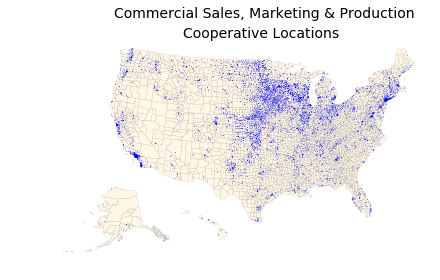

CPU times: user 11.4 s, sys: 1.65 s, total: 13 s
Wall time: 11 s


<Figure size 600x400 with 0 Axes>

In [25]:
%%time
ax21 = plt.axes()  # standard axes
ax22 = plt.axes([0.04, 0.065, 0.27, 0.27])
ax23 = plt.axes([0.32, 0.12, 0.12, 0.12])
legend2 = plt.axes([0.70, 0.20, 0.1, 0.1])

ax21.set_aspect('equal')
ax22.set_aspect('equal')
ax23.set_aspect('equal')

plt.text(-5.3, 7, 'Commercial Sales, Marketing & Production', fontsize=14)
plt.text(-3.7, 6.3, 'Cooperative Locations', fontsize=14)

# Contiguous data
contig_counties.plot(ax=ax21, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
contig_comm_points.plot(ax=ax21, facecolor='blue', edgecolor='none', markersize=0.3)

# Alaska data
alaska_counties.plot(ax=ax22, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
ak_comm_points.plot(ax=ax22, facecolor='blue', edgecolor='none', markersize=0.3)

# Hawaii data
hawaii_counties.plot(ax=ax23, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
hi_comm_points.plot(ax=ax23, facecolor='blue', edgecolor='none', markersize=0.3)

ax21.axis('off')
ax22.axis('off')
ax23.axis('off')
legend2.axis('off')

plt.savefig(dir + 'commercial_locations.png', dpi=1080)
plt.show()
plt.clf()

<h1>Map 3 - Financial Services Cooperative Locations</h1>

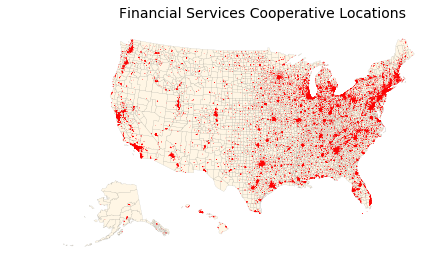

CPU times: user 15.9 s, sys: 1.65 s, total: 17.5 s
Wall time: 15.5 s


<Figure size 600x400 with 0 Axes>

In [26]:
%%time
ax31 = plt.axes()  # 48 States
ax32 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax33 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend3 = plt.axes([0.70, 0.20, 0.1, 0.1]) # Legened

ax31.set_aspect('equal')
ax32.set_aspect('equal')
ax33.set_aspect('equal')

plt.text(-5.2, 6.8, 'Financial Services Cooperative Locations', fontsize=14)

# Contiguous data
contig_counties.plot(ax=ax31, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
contig_fin_points.plot(ax=ax31, facecolor='red', edgecolor='none', markersize=0.3)

# Alaska data
alaska_counties.plot(ax=ax32, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
ak_fin_points.plot(ax=ax32, facecolor='red', edgecolor='none', markersize=0.3)

# Hawaii data
hawaii_counties.plot(ax=ax33, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
hi_fin_points.plot(ax=ax33, facecolor='red', edgecolor='none', markersize=0.3)

ax31.axis('off')
ax32.axis('off')
ax33.axis('off')
legend3.axis('off')

plt.savefig(dir + 'financial_locations.png', dpi=1080)
plt.show()
plt.clf()

<h1>Map 4 - Social & Public Services Cooperative Locations</h1>

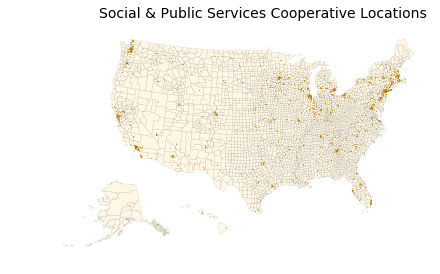

CPU times: user 10.2 s, sys: 1.65 s, total: 11.9 s
Wall time: 9.82 s


<Figure size 600x400 with 0 Axes>

In [27]:
%%time
ax41 = plt.axes()  # 48 States
ax42 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax43 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend4 = plt.axes([0.70, 0.20, 0.1, 0.1]) # Legened

ax41.set_aspect('equal')
ax42.set_aspect('equal')
ax43.set_aspect('equal')

plt.text(-5.65, 6.8, 'Social & Public Services Cooperative Locations', fontsize=14)

# Contiguous data
contig_counties.plot(ax=ax41, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
contig_soc_points.plot(ax=ax41, facecolor='orange', edgecolor='black', linewidth=0.05, markersize=0.5)

# Alaska data
alaska_counties.plot(ax=ax42, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
ak_soc_points.plot(ax=ax42, facecolor='orange', edgecolor='black', linewidth=0.05, markersize=0.5)

# Hawaii data
hawaii_counties.plot(ax=ax43, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
hi_soc_points.plot(ax=ax43, facecolor='orange', edgecolor='black', linewidth=0.05, markersize=0.5)

ax41.axis('off')
ax42.axis('off')
ax43.axis('off')
legend4.axis('off')

plt.savefig(dir + 'social_locations.png', dpi=1080)
plt.show()
plt.clf()

<h1>Map 5 - Utility Cooperative Locations</h1>

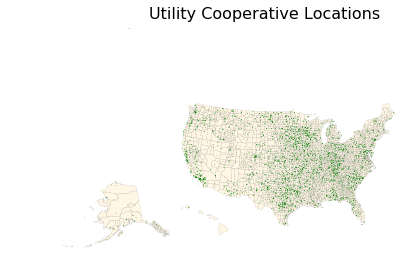

CPU times: user 9.76 s, sys: 1.72 s, total: 11.5 s
Wall time: 9.39 s


<Figure size 600x400 with 0 Axes>

In [28]:
%%time
ax51 = plt.axes()  # 48 States
ax52 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax53 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend5 = plt.axes([0.70, 0.20, 0.1, 0.1]) # Legened

ax51.set_aspect('equal')
ax52.set_aspect('equal')
ax53.set_aspect('equal')

plt.text(-4.5, 6.8, 'Utility Cooperative Locations', fontsize=16)

# Contiguous data
contig_counties.plot(ax=ax51, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
contig_util_points.plot(ax=ax51, facecolor='green', edgecolor='none', markersize=0.5)

# Alaska data
alaska_counties.plot(ax=ax52, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
ak_util_points.plot(ax=ax52, facecolor='green', edgecolor='none', markersize=0.5)

# Hawaii data
hawaii_counties.plot(ax=ax53, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
hi_util_points.plot(ax=ax53, facecolor='green', edgecolor='none', markersize=0.5)

ax51.axis('off')
ax52.axis('off')
ax53.axis('off')
legend5.axis('off')

plt.savefig(dir + 'utility_locations.png', dpi=1080)
plt.show()
plt.clf()

<h1>Map 6 - Cooperative Locations: Employee Count</h1>

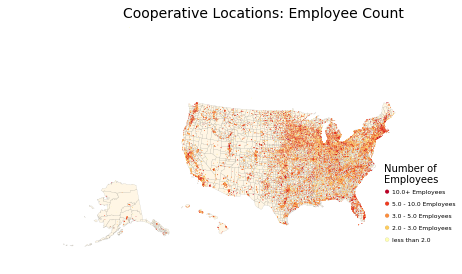

CPU times: user 18.5 s, sys: 1.75 s, total: 20.2 s
Wall time: 18.1 s


<Figure size 600x400 with 0 Axes>

In [29]:
%%time
ax61 = plt.axes()  # 48 States
ax62 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax63 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend6 = plt.axes([0.69, 0.2, 0.1, 0.1]) # Legend

ax61.set_aspect('equal')
ax62.set_aspect('equal')
ax63.set_aspect('equal')

plt.text(-5, 6.8, 'Cooperative Locations: Employee Count', fontsize=14)

# Contiguous data
contig_counties.plot(ax=ax61, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
contig_points.plot(ax=ax61, facecolor=contig_points['Emp_Color'], edgecolor='none', markersize=0.4)

# Alaska data
alaska_counties.plot(ax=ax62, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
alaska_points.plot(ax=ax62, facecolor=alaska_points['Emp_Color'], edgecolor='none', markersize=0.4)

# Hawaii data
hawaii_counties.plot(ax=ax63, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
hawaii_points.plot(ax=ax63, facecolor=hawaii_points['Emp_Color'], edgecolor='none', markersize=0.4)

ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
fifth_quantile = Circle((10, -2), 2, fc='#bd0026', edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fifth_quantile)
fourth_quantile = Circle((10, -14), 2, fc="#f03b20", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fourth_quantile)
third_quantile = Circle((10, -26), 2, fc="#fd8d3c", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(third_quantile)
second_quantile = Circle((10, -38), 2, fc="#fecc5c", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(second_quantile)
first_quantile = Circle((10, -50), 2, fc="#ffffb2", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(first_quantile)
legend6.add_artist(ada)

legend6.text(1.05, 1.47, 'Number of', fontsize=10)
legend6.text(1.05, 1.07, 'Employees', fontsize=10)
legend6.text(1.22, 0.69, str(employee_quantiles[3]) + '+ Employees', fontsize=6)
legend6.text(1.22, 0.28, str(employee_quantiles[2]) + ' - ' + str(employee_quantiles[3]) + ' Employees', fontsize=6)
legend6.text(1.22, -0.14, str(employee_quantiles[1]) + ' - ' + str(employee_quantiles[2]) + ' Employees', fontsize=6)
legend6.text(1.22, -0.56, str(employee_quantiles[0]) + ' - ' + str(employee_quantiles[1]) + ' Employees', fontsize=6)
legend6.text(1.22, -0.97, 'less than ' + str(employee_quantiles[0]), fontsize=6)

ax61.axis('off')
ax62.axis('off')
ax63.axis('off')
legend6.axis('off')

plt.savefig(dir + 'all_locations_employees.png', dpi=1080)
plt.show()
plt.clf()

<h1>Map 7 - Commercial Sales, Marketing & Production Cooperative Locations: Employee Count</h1>

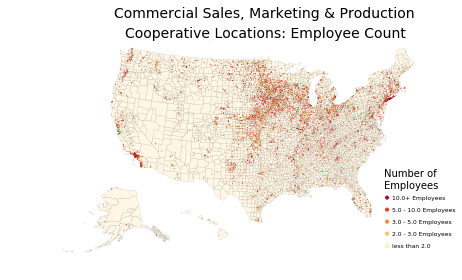

CPU times: user 12.5 s, sys: 1.69 s, total: 14.2 s
Wall time: 12.1 s


<Figure size 600x400 with 0 Axes>

In [30]:
%%time
ax71 = plt.axes()  # 48 States
ax72 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax73 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend7 = plt.axes([0.69, 0.20, 0.1, 0.1]) # Legend

ax71.set_aspect('equal')
ax72.set_aspect('equal')
ax73.set_aspect('equal')

plt.text(-5.2, 7, 'Commercial Sales, Marketing & Production', fontsize=14)
plt.text(-4.95, 6.3, 'Cooperative Locations: Employee Count', fontsize=14)

# Contiguous data
contig_counties.plot(ax=ax71, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
contig_comm_points.plot(ax=ax71, facecolor=contig_comm_points['Emp_Color'], edgecolor='black', linewidth=0.025, markersize=0.5)

# Alaska data
alaska_counties.plot(ax=ax72, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
ak_comm_points.plot(ax=ax72, facecolor=ak_comm_points['Emp_Color'], edgecolor='black', linewidth=0.025, markersize=0.5)

# Hawaii data
hawaii_counties.plot(ax=ax73, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
hi_comm_points.plot(ax=ax73, facecolor=hi_comm_points['Emp_Color'], edgecolor='black', linewidth=0.025, markersize=0.5)

ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
fifth_quantile = Circle((10, -2), 2, fc='#bd0026', edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fifth_quantile)
fourth_quantile = Circle((10, -14), 2, fc="#f03b20", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fourth_quantile)
third_quantile = Circle((10, -26), 2, fc="#fd8d3c", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(third_quantile)
second_quantile = Circle((10, -38), 2, fc="#fecc5c", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(second_quantile)
first_quantile = Circle((10, -50), 2, fc="#ffffb2", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(first_quantile)
legend7.add_artist(ada)

legend7.text(1.05, 1.47, 'Number of', fontsize=10)
legend7.text(1.05, 1.07, 'Employees', fontsize=10)
legend7.text(1.22, 0.69, str(employee_quantiles[3]) + '+ Employees', fontsize=6)
legend7.text(1.22, 0.28, str(employee_quantiles[2]) + ' - ' + str(employee_quantiles[3]) + ' Employees', fontsize=6)
legend7.text(1.22, -0.14, str(employee_quantiles[1]) + ' - ' + str(employee_quantiles[2]) + ' Employees', fontsize=6)
legend7.text(1.22, -0.56, str(employee_quantiles[0]) + ' - ' + str(employee_quantiles[1]) + ' Employees', fontsize=6)
legend7.text(1.22, -0.97, 'less than ' + str(employee_quantiles[0]), fontsize=6)

ax71.axis('off')
ax72.axis('off')
ax73.axis('off')
legend7.axis('off')

plt.savefig(dir + 'commercial_employees.png', dpi=1080)
plt.show()
plt.clf()

<h1>Map 8 - Financial Services Cooperative Locations: Employee Count</h1>

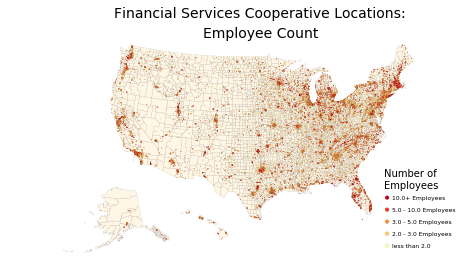

CPU times: user 20.9 s, sys: 1.79 s, total: 22.6 s
Wall time: 20.5 s


<Figure size 600x400 with 0 Axes>

In [31]:
%%time
ax81 = plt.axes()  # 48 States
ax82 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax83 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend8 = plt.axes([0.69, 0.20, 0.1, 0.1]) # Legend

ax81.set_aspect('equal')
ax82.set_aspect('equal')
ax83.set_aspect('equal')

plt.text(-5.2, 7, 'Financial Services Cooperative Locations:', fontsize=14)
plt.text(-3.15, 6.3, 'Employee Count', fontsize=14)

# Contiguous data
contig_counties.plot(ax=ax81, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
contig_fin_points.plot(ax=ax81, facecolor=contig_fin_points['Emp_Color'], edgecolor='black', linewidth=0.025, markersize=0.5)

# Alaska data
alaska_counties.plot(ax=ax82, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
ak_fin_points.plot(ax=ax82, facecolor=ak_fin_points['Emp_Color'], edgecolor='black', linewidth=0.025, markersize=0.5)

# Hawaii data
hawaii_counties.plot(ax=ax83, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
hi_fin_points.plot(ax=ax83, facecolor=hi_fin_points['Emp_Color'], edgecolor='black', linewidth=0.025, markersize=0.5)

ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
fifth_quantile = Circle((10, -2), 2, fc='#bd0026', edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fifth_quantile)
fourth_quantile = Circle((10, -14), 2, fc="#f03b20", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fourth_quantile)
third_quantile = Circle((10, -26), 2, fc="#fd8d3c", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(third_quantile)
second_quantile = Circle((10, -38), 2, fc="#fecc5c", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(second_quantile)
first_quantile = Circle((10, -50), 2, fc="#ffffb2", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(first_quantile)
legend8.add_artist(ada)

legend8.text(1.05, 1.47, 'Number of', fontsize=10)
legend8.text(1.05, 1.07, 'Employees', fontsize=10)
legend8.text(1.22, 0.69, str(employee_quantiles[3]) + '+ Employees', fontsize=6)
legend8.text(1.22, 0.28, str(employee_quantiles[2]) + ' - ' + str(employee_quantiles[3]) + ' Employees', fontsize=6)
legend8.text(1.22, -0.14, str(employee_quantiles[1]) + ' - ' + str(employee_quantiles[2]) + ' Employees', fontsize=6)
legend8.text(1.22, -0.56, str(employee_quantiles[0]) + ' - ' + str(employee_quantiles[1]) + ' Employees', fontsize=6)
legend8.text(1.22, -0.97, 'less than ' + str(employee_quantiles[0]), fontsize=6)

ax81.axis('off')
ax82.axis('off')
ax83.axis('off')
legend8.axis('off')

plt.savefig(dir + 'financial_employees.png', dpi=1080)
plt.show()
plt.clf()

<h1>Map 9 - Social & Public Services Cooperative Locations: Employee Count</h1>

In [32]:
%%time
ax91 = plt.axes()  # 48 States
ax92 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax93 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend9 = plt.axes([0.69, 0.20, 0.1, 0.1]) # Legend

ax91.set_aspect('equal')
ax92.set_aspect('equal')
ax93.set_aspect('equal')

plt.text(-4.6, 7, 'Social & Public Services Cooperative', fontsize=14)
plt.text(-3.9, 6.3, 'Locations: Employee Count', fontsize=14)

# Contiguous data
contig_counties.plot(ax=ax91, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
contig_soc_points.plot(ax=ax91, facecolor=contig_soc_points['Emp_Color'], edgecolor='black', linewidth=0.025, markersize=0.5)

# Alaska data
alaska_counties.plot(ax=ax92, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
ak_soc_points.plot(ax=ax92, facecolor=ak_soc_points['Emp_Color'], edgecolor='black', linewidth=0.025, markersize=0.5)

# Hawaii data
hawaii_counties.plot(ax=ax93, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
hi_soc_points.plot(ax=ax93, facecolor=hi_soc_points['Emp_Color'], edgecolor='black', linewidth=0.025, markersize=0.5)

ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
fifth_quantile = Circle((10, -2), 2, fc='#bd0026', edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fifth_quantile)
fourth_quantile = Circle((10, -14), 2, fc="#f03b20", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fourth_quantile)
third_quantile = Circle((10, -26), 2, fc="#fd8d3c", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(third_quantile)
second_quantile = Circle((10, -38), 2, fc="#fecc5c", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(second_quantile)
first_quantile = Circle((10, -50), 2, fc="#ffffb2", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(first_quantile)
legend9.add_artist(ada)

legend9.text(1.05, 1.47, 'Number of', fontsize=10)
legend9.text(1.05, 1.07, 'Employees', fontsize=10)
legend9.text(1.22, 0.69, str(employee_quantiles[3]) + '+ Employees', fontsize=6)
legend9.text(1.22, 0.28, str(employee_quantiles[2]) + ' - ' + str(employee_quantiles[3]) + ' Employees', fontsize=6)
legend9.text(1.22, -0.14, str(employee_quantiles[1]) + ' - ' + str(employee_quantiles[2]) + ' Employees', fontsize=6)
legend9.text(1.22, -0.56, str(employee_quantiles[0]) + ' - ' + str(employee_quantiles[1]) + ' Employees', fontsize=6)
legend9.text(1.22, -0.97, 'less than ' + str(employee_quantiles[0]), fontsize=6)

ax91.axis('off')
ax92.axis('off')
ax93.axis('off')
legend9.axis('off')

plt.savefig(dir + 'social_employees.png', dpi=1080)
plt.show()
plt.clf()

CPU times: user 10.4 s, sys: 1.68 s, total: 12 s
Wall time: 9.97 s


<Figure size 600x400 with 0 Axes>

<h1>Map 10 - Utility Cooperative Locations: Employee Count</h1>

In [33]:
%%time
ax101 = plt.axes()  # 48 States
ax102 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax103 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend10 = plt.axes([0.69, 0.20, 0.1, 0.1]) # Legend

ax101.set_aspect('equal')
ax102.set_aspect('equal')
ax103.set_aspect('equal')

plt.text(-4.0, 7, 'Utility Cooperative Locations:', fontsize=14)
plt.text(-3.0, 6.3, 'Employee Count', fontsize=14)

# Contiguous data
contig_counties.plot(ax=ax101, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
contig_util_points.plot(ax=ax101, facecolor=contig_util_points['Emp_Color'], edgecolor='black', linewidth=0.025, markersize=0.5)

# Alaska data
alaska_counties.plot(ax=ax102, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
ak_util_points.plot(ax=ax102, facecolor=ak_util_points['Emp_Color'], edgecolor='black', linewidth=0.025, markersize=0.5)

# Hawaii data
hawaii_counties.plot(ax=ax103, facecolor='#ffefcc', linestyle='-', alpha=0.5, edgecolor='black', linewidth=0.1)
hi_util_points.plot(ax=ax103, facecolor=hi_util_points['Emp_Color'], edgecolor='black', linewidth=0.025, markersize=0.5)

ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
fifth_quantile = Circle((10, -2), 2, fc='#bd0026', edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fifth_quantile)
fourth_quantile = Circle((10, -14), 2, fc="#f03b20", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fourth_quantile)
third_quantile = Circle((10, -26), 2, fc="#fd8d3c", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(third_quantile)
second_quantile = Circle((10, -38), 2, fc="#fecc5c", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(second_quantile)
first_quantile = Circle((10, -50), 2, fc="#ffffb2", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(first_quantile)
legend10.add_artist(ada)

legend10.text(1.05, 1.47, 'Number of', fontsize=10)
legend10.text(1.05, 1.07, 'Employees', fontsize=10)
legend10.text(1.22, 0.69, str(employee_quantiles[3]) + '+ Employees', fontsize=6)
legend10.text(1.22, 0.28, str(employee_quantiles[2]) + ' - ' + str(employee_quantiles[3]) + ' Employees', fontsize=6)
legend10.text(1.22, -0.14, str(employee_quantiles[1]) + ' - ' + str(employee_quantiles[2]) + ' Employees', fontsize=6)
legend10.text(1.22, -0.56, str(employee_quantiles[0]) + ' - ' + str(employee_quantiles[1]) + ' Employees', fontsize=6)
legend10.text(1.22, -0.97, 'less than ' + str(employee_quantiles[0]), fontsize=6)

ax101.axis('off')
ax102.axis('off')
ax103.axis('off')
legend10.axis('off')

plt.savefig(dir + 'utility_employees.png', dpi=1080)
plt.show()
plt.clf()

CPU times: user 9.97 s, sys: 1.7 s, total: 11.7 s
Wall time: 9.59 s


<Figure size 600x400 with 0 Axes>

<h1>Map 11 - Cooperative Locations: Congressional Districts</h1>

In [34]:
%%time
ax111 = plt.axes()  # 48 States
ax112 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax113 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend11 = plt.axes([0.68, 0.2, 0.1, 0.1]) # Legend

ax111.set_aspect('equal')
ax112.set_aspect('equal')
ax113.set_aspect('equal')

plt.text(-5.4, 6.8, 'Cooperative Locations: Congressional Districts', fontsize=14)

# Contiguous data
for i in range(contig_districts.shape[0]):
    if i+1 <= contig_districts.shape[0]:
        contig_districts[i:i+1].plot(ax=ax111, facecolor=contig_colors[i], edgecolor='black', linewidth=0.1)

# Alaska data
ak_districts.plot(ax=ax112, facecolor=ak_color, edgecolor='black', linewidth=0.1)

# Hawaii data
for i in range(hi_districts.shape[0]):
    if i+1 <= hi_districts.shape[0]:
        hi_districts[i:i+1].plot(ax=ax113, facecolor=hi_colors[i], edgecolor='black', linewidth=0.1)

ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
fifth_quantile = Circle((10, -2), 2, fc='#253494', edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fifth_quantile)
fourth_quantile = Circle((10, -14), 2, fc="#2c7fb8", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fourth_quantile)
third_quantile = Circle((10, -26), 2, fc="#41b6c4", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(third_quantile)
second_quantile = Circle((10, -38), 2, fc="#a1dab4", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(second_quantile)
first_quantile = Circle((10, -50), 2, fc="#ffffcc", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(first_quantile)
legend11.add_artist(ada)

legend11.text(1.05, 1.47, 'Cooperatives per', fontsize=10)
legend11.text(1.05, 1.07, '100 Sq. Miles', fontsize=10)
legend11.text(1.22, 0.69, str(overall_quantiles[3])[:5] + '+', fontsize=6)
legend11.text(1.22, 0.28, str(overall_quantiles[2])[:5] + ' - ' + str(overall_quantiles[3])[:5], fontsize=6)
legend11.text(1.22, -0.14, str(overall_quantiles[1])[:5] + ' - ' + str(overall_quantiles[2])[:5], fontsize=6)
legend11.text(1.22, -0.56, str(overall_quantiles[0])[:5] + ' - ' + str(overall_quantiles[1])[:5], fontsize=6)
legend11.text(1.22, -0.97, 'less than ' + str(overall_quantiles[0])[:5], fontsize=6)

ax111.axis('off')
ax112.axis('off')
ax113.axis('off')
legend11.axis('off')

plt.savefig(dir + 'all_congressional_dist.png', dpi=1080)
plt.show()
plt.clf()

CPU times: user 1min 46s, sys: 1min 19s, total: 3min 6s
Wall time: 1min 23s


<Figure size 600x400 with 0 Axes>

<h1>Map 12 - Commercial Sales, Marketing & Production Cooperative Locations: Congressional Districts</h1>

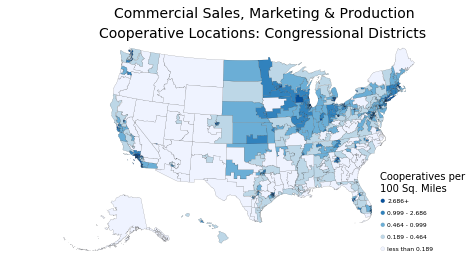

CPU times: user 1min 46s, sys: 1min 19s, total: 3min 5s
Wall time: 1min 23s


<Figure size 600x400 with 0 Axes>

In [35]:
%%time
ax121 = plt.axes()  # 48 States
ax122 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax123 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend12 = plt.axes([0.68, 0.2, 0.1, 0.1]) # Legend

ax121.set_aspect('equal')
ax122.set_aspect('equal')
ax123.set_aspect('equal')

plt.text(-5.1, 7.1, 'Commercial Sales, Marketing & Production', fontsize=14)
plt.text(-5.45, 6.4, 'Cooperative Locations: Congressional Districts', fontsize=14)

# Contiguous data
for i in range(contig_districts.shape[0]):
    if i+1 <= contig_districts.shape[0]:
        contig_districts[i:i+1].plot(ax=ax121, facecolor=contig_comm_colors[i], edgecolor='black', linewidth=0.1)

# Alaska data
ak_districts.plot(ax=ax122, facecolor=ak_comm_color, edgecolor='black', linewidth=0.1)

# Hawaii data
for i in range(hi_districts.shape[0]):
    if i+1 <= hi_districts.shape[0]:
        hi_districts[i:i+1].plot(ax=ax123, facecolor=hi_comm_colors[i], edgecolor='black', linewidth=0.1)

ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
fifth_quantile = Circle((10, -2), 2, fc='#08519c', edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fifth_quantile)
fourth_quantile = Circle((10, -14), 2, fc="#3182bd", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fourth_quantile)
third_quantile = Circle((10, -26), 2, fc="#6baed6", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(third_quantile)
second_quantile = Circle((10, -38), 2, fc="#bdd7e7", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(second_quantile)
first_quantile = Circle((10, -50), 2, fc="#eff3ff", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(first_quantile)
legend12.add_artist(ada)

legend12.text(1.05, 1.47, 'Cooperatives per', fontsize=10)
legend12.text(1.05, 1.07, '100 Sq. Miles', fontsize=10)
legend12.text(1.22, 0.69, str(comm_quantiles[3])[:5] + '+', fontsize=6)
legend12.text(1.22, 0.28, str(comm_quantiles[2])[:5] + ' - ' + str(comm_quantiles[3])[:5], fontsize=6)
legend12.text(1.22, -0.14, str(comm_quantiles[1])[:5] + ' - ' + str(comm_quantiles[2])[:5], fontsize=6)
legend12.text(1.22, -0.56, str(comm_quantiles[0])[:5] + ' - ' + str(comm_quantiles[1])[:5], fontsize=6)
legend12.text(1.22, -0.97, 'less than ' + str(comm_quantiles[0])[:5], fontsize=6)

ax121.axis('off')
ax122.axis('off')
ax123.axis('off')
legend12.axis('off')

plt.savefig(dir + 'comm_congressional_dist.png', dpi=1080)
plt.show()
plt.clf()

<h1>Map 13 - Financial Services Cooperative Locations: Congressional Districts</h1>

In [36]:
%%time
ax131 = plt.axes()  # 48 States
ax132 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax133 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend13 = plt.axes([0.68, 0.2, 0.1, 0.1]) # Legend

ax131.set_aspect('equal')
ax132.set_aspect('equal')
ax133.set_aspect('equal')

plt.text(-5.0, 7.1, 'Financial Services Cooperative Locations:', fontsize=14)
plt.text(-3.5, 6.4, 'Congressional Districts', fontsize=14)

# Contiguous data
for i in range(contig_districts.shape[0]):
    if i+1 <= contig_districts.shape[0]:
        contig_districts[i:i+1].plot(ax=ax131, facecolor=contig_fin_colors[i], edgecolor='black', linewidth=0.1)

# Alaska data
ak_districts.plot(ax=ax132, facecolor=ak_fin_color, edgecolor='black', linewidth=0.1)

# Hawaii data
for i in range(hi_districts.shape[0]):
    if i+1 <= hi_districts.shape[0]:
        hi_districts[i:i+1].plot(ax=ax133, facecolor=hi_fin_colors[i], edgecolor='black', linewidth=0.1)

ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
fifth_quantile = Circle((10, -2), 2, fc='#a50f15', edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fifth_quantile)
fourth_quantile = Circle((10, -14), 2, fc="#de2d26", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fourth_quantile)
third_quantile = Circle((10, -26), 2, fc="#fb6a4a", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(third_quantile)
second_quantile = Circle((10, -38), 2, fc="#fcae91", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(second_quantile)
first_quantile = Circle((10, -50), 2, fc="#fee5d9", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(first_quantile)
legend13.add_artist(ada)

legend13.text(1.05, 1.47, 'Cooperatives per', fontsize=10)
legend13.text(1.05, 1.07, '100 Sq. Miles', fontsize=10)
legend13.text(1.22, 0.69, str(fin_quantiles[3])[:5] + '+', fontsize=6)
legend13.text(1.22, 0.28, str(fin_quantiles[2])[:5] + ' - ' + str(fin_quantiles[3])[:5], fontsize=6)
legend13.text(1.22, -0.14, str(fin_quantiles[1])[:5] + ' - ' + str(fin_quantiles[2])[:5], fontsize=6)
legend13.text(1.22, -0.56, str(fin_quantiles[0])[:5] + ' - ' + str(fin_quantiles[1])[:5], fontsize=6)
legend13.text(1.22, -0.97, 'less than ' + str(fin_quantiles[0])[:5], fontsize=6)

ax131.axis('off')
ax132.axis('off')
ax133.axis('off')
legend13.axis('off')

plt.savefig(dir + 'financial_congressional_dist.png', dpi=1080)
plt.show()
plt.clf()

CPU times: user 1min 47s, sys: 1min 20s, total: 3min 8s
Wall time: 1min 25s


<Figure size 600x400 with 0 Axes>

<h1>Map 14 - Social & Public Services Cooperative Locations: Congressional Districts</h1>

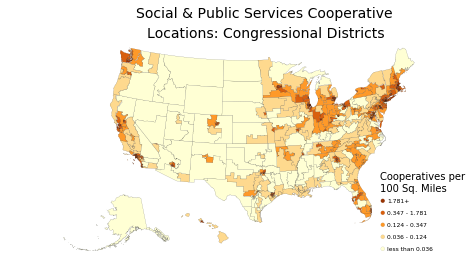

CPU times: user 1min 43s, sys: 1min 19s, total: 3min 2s
Wall time: 1min 20s


<Figure size 600x400 with 0 Axes>

In [37]:
%%time
ax141 = plt.axes()  # 48 States
ax142 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax143 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend14 = plt.axes([0.68, 0.2, 0.1, 0.1]) # Legend

ax141.set_aspect('equal')
ax142.set_aspect('equal')
ax143.set_aspect('equal')

plt.text(-4.6, 7.1, 'Social & Public Services Cooperative', fontsize=14)
plt.text(-4.35, 6.4, 'Locations: Congressional Districts', fontsize=14)

# Contiguous data
for i in range(contig_districts.shape[0]):
    if i+1 <= contig_districts.shape[0]:
        contig_districts[i:i+1].plot(ax=ax141, facecolor=contig_soc_colors[i], edgecolor='black', linewidth=0.1)

# Alaska data
ak_districts.plot(ax=ax142, facecolor=ak_soc_color, edgecolor='black', linewidth=0.1)

# Hawaii data
for i in range(hi_districts.shape[0]):
    if i+1 <= hi_districts.shape[0]:
        hi_districts[i:i+1].plot(ax=ax143, facecolor=hi_soc_colors[i], edgecolor='black', linewidth=0.1)

ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
fifth_quantile = Circle((10, -2), 2, fc='#993404', edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fifth_quantile)
fourth_quantile = Circle((10, -14), 2, fc="#d95f0e", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fourth_quantile)
third_quantile = Circle((10, -26), 2, fc="#fe9929", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(third_quantile)
second_quantile = Circle((10, -38), 2, fc="#fed98e", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(second_quantile)
first_quantile = Circle((10, -50), 2, fc="#ffffd4", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(first_quantile)
legend14.add_artist(ada)

legend14.text(1.05, 1.47, 'Cooperatives per', fontsize=10)
legend14.text(1.05, 1.07, '100 Sq. Miles', fontsize=10)
legend14.text(1.22, 0.69, str(soc_quantiles[3])[:5] + '+', fontsize=6)
legend14.text(1.22, 0.28, str(soc_quantiles[2])[:5] + ' - ' + str(soc_quantiles[3])[:5], fontsize=6)
legend14.text(1.22, -0.14, str(soc_quantiles[1])[:5] + ' - ' + str(soc_quantiles[2])[:5], fontsize=6)
legend14.text(1.22, -0.56, str(soc_quantiles[0])[:5] + ' - ' + str(soc_quantiles[1])[:5], fontsize=6)
legend14.text(1.22, -0.97, 'less than ' + str(soc_quantiles[0])[:5], fontsize=6)

ax141.axis('off')
ax142.axis('off')
ax143.axis('off')
legend14.axis('off')

plt.savefig(dir + 'social_congressional_dist.png', dpi=1080)
plt.show()
plt.clf()

<h1>Map 15 - Utility Cooperative Locations: Congressional Districts</h1>

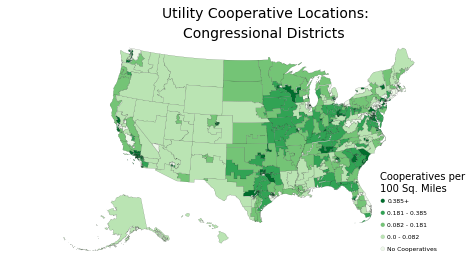

CPU times: user 1min 43s, sys: 1min 18s, total: 3min 2s
Wall time: 1min 20s


<Figure size 600x400 with 0 Axes>

In [38]:
%%time
ax151 = plt.axes()  # 48 States
ax152 = plt.axes([0.04, 0.065, 0.27, 0.27]) # Alaska
ax153 = plt.axes([0.32, 0.12, 0.12, 0.12]) # Hawaii
legend15 = plt.axes([0.68, 0.2, 0.1, 0.1]) # Legend

ax151.set_aspect('equal')
ax152.set_aspect('equal')
ax153.set_aspect('equal')

plt.text(-4.0, 7.1, 'Utility Cooperative Locations:', fontsize=14)
plt.text(-3.5, 6.4, 'Congressional Districts', fontsize=14)

# Contiguous data
for i in range(contig_districts.shape[0]):
    if i+1 <= contig_districts.shape[0]:
        contig_districts[i:i+1].plot(ax=ax151, facecolor=contig_util_colors[i], edgecolor='black', linewidth=0.1)

# Alaska data
ak_districts.plot(ax=ax152, facecolor=ak_util_color, edgecolor='black', linewidth=0.1)

# Hawaii data
for i in range(hi_districts.shape[0]):
    if i+1 <= hi_districts.shape[0]:
        hi_districts[i:i+1].plot(ax=ax153, facecolor=hi_util_colors[i], edgecolor='black', linewidth=0.1)

ada = AnchoredDrawingArea(0, 0, 0, 0, loc=1, pad=0., frameon=False)
fifth_quantile = Circle((10, -2), 2, fc='#006d2c', edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fifth_quantile)
fourth_quantile = Circle((10, -14), 2, fc="#31a354", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(fourth_quantile)
third_quantile = Circle((10, -26), 2, fc="#74c476", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(third_quantile)
second_quantile = Circle((10, -38), 2, fc="#bae4b3", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(second_quantile)
first_quantile = Circle((10, -50), 2, fc="#edf8e9", edgecolor='black', linewidth=0.05)
ada.drawing_area.add_artist(first_quantile)
legend15.add_artist(ada)

legend15.text(1.05, 1.47, 'Cooperatives per', fontsize=10)
legend15.text(1.05, 1.07, '100 Sq. Miles', fontsize=10)
legend15.text(1.22, 0.69, str(util_quantiles[3])[:5] + '+', fontsize=6)
legend15.text(1.22, 0.28, str(util_quantiles[2])[:5] + ' - ' + str(util_quantiles[3])[:5], fontsize=6)
legend15.text(1.22, -0.14, str(util_quantiles[1])[:5] + ' - ' + str(util_quantiles[2])[:5], fontsize=6)
legend15.text(1.22, -0.56, str(util_quantiles[0])[:5] + ' - ' + str(util_quantiles[1])[:5], fontsize=6)
if str(util_quantiles[0])[:5] == '0.0':
    legend15.text(1.22, -0.97, 'No Cooperatives', fontsize=6)
else:
    legend15.text(1.22, -0.97, 'less than ' + str(util_quantiles[0])[:5], fontsize=6)

ax151.axis('off')
ax152.axis('off')
ax153.axis('off')
legend15.axis('off')

plt.savefig(dir + 'utility_congressional_dist.png', dpi=1080)
plt.show()
plt.clf()